Preprocessing...
Obtaining Image Data...
Obtaining Depth Data...
Forming Network...
(1304, 240, 320, 3)
(145, 240, 320, 3)
(1304, 240, 320, 1)
(145, 240, 320, 1)


/Users/williamherbosch/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:228: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 320, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 320, 64) 36928       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

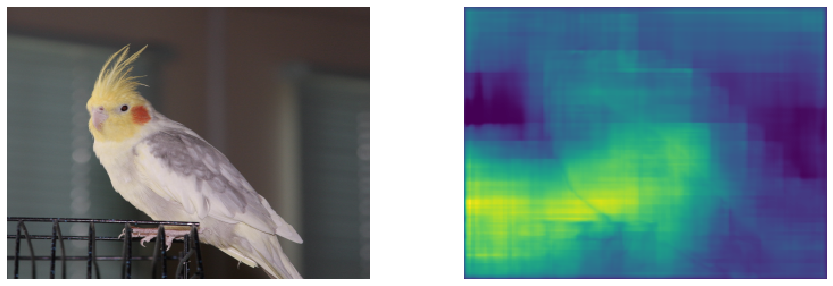

In [23]:
#William Herbosch - UCL Research Project 2018-19 - Virtual Annotator System
#Predicting Depth Maps from RGB Images - UNet CNN
#
#This code is wholy the work of the student, though the work is heavily influenced by the following paper:
#https://arxiv.org/pdf/1904.10230.pdf

#For Google Colabratory, please ensure the connection to the local runtime. 
#Note: This will assume the program to run in the local directory.

## Imports
from PIL import Image  #Python Image Library Operator
import glob
import cv2
import random
import sys
import scipy.io #For reading in the depth images
import scipy.misc
import numpy as np  #Numerical computations
from matplotlib import gridspec  #Needed for plotting the colourmap
from matplotlib import pyplot as plt  #Needed for plotting the images
from sklearn.model_selection import train_test_split as tts  #Splits data

#Neural Network
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as keras
keras.clear_session()

#Needed for reading files in test directory
from os import listdir, mkdir
from os.path import isfile, join
import os

##############################################################################################################################
## SETTINGS. PLEASE READ:  

#Directories for train and test:
Name_of_RBGImages_directory = 'NYU_Images'
Name_of_DepthImages_directory = 'NYU_Depths'

#Learning in groups of
batch_size = 4

#Learning iterations 
epochs = 1

#Train the model (True) or load in a model (False):
Train = False

#Produce a depth map for a single image (True) or a directory (False) that's rooted in TestImages: 
Image_or_Directory = True
#Specify the name of this image/directory
To_Be_Tested = "THETestImages/Bird.jpg" #"NYU_Images/NYU_RGBimage_1.jpg"
#Note: When testing for a directory, please ensure any existing 'RGB_outs' and 'Dep_outs' folders are not present in 

#Show images. Please Set to False is training for a directory for more than 20 images. 
Show_Images = True

##############################################################################################################################
## Globals
#Paths for directories
IMG_DIR = 'tensorflow/models/research/deeplab/g3doc/img/TestImages/'
RGB_DIR = IMG_DIR + Name_of_RBGImages_directory
Dep_DIR = IMG_DIR + Name_of_DepthImages_directory

#List storage for the images/depths
RGBImage_list = []  
DepthImage_list = []

#Resize
resize_H = 240
resize_W = 320

## Methods
#Preprocess and obtain images/depths
def preprocess():
    #plt.figure(figsize = (15, 5))
    #grid_spec = gridspec.GridSpec(1, 2, width_ratios=[6, 7.4])
    #Obtain images
    print("Obtaining Image Data...")
    #plt.subplot(grid_spec[0])
    #plt.axis('off')
    #plt.title('Input RBG Image') 
    #Obtain all file names within the test image directory
    RGBimgs = [f for f in listdir(RGB_DIR) if isfile(join(RGB_DIR, f))]
    RGBimgs.remove('.DS_Store')
    RGBimgs.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #for each image, open and convert to np.array and store in list
    for i in RGBimgs:
        im = Image.open(RGB_DIR + '/' + i)
        im = np.array(im)
        RGBImage_list.append(im)
    #plt.imshow(RGBImage_list[0])
    #Do the same for the depth images
    print("Obtaining Depth Data...")
    #plt.subplot(grid_spec[1])
    #plt.axis('off')
    #plt.title('True Depth Image')
    #Obtain all file names within the test image directory
    DEPimgs = [f for f in listdir(Dep_DIR) if isfile(join(Dep_DIR, f))]
    DEPimgs.remove('.DS_Store')
    DEPimgs.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #For each depth image, convert from mat to np.array and store in list
    for i in DEPimgs: 
        #Importing .mat data (i.e. the depth maps) into python as arrays    
        mat = scipy.io.loadmat(Dep_DIR + '/' + i)
        list_values = [v for v in mat.values()]
        this_depth_map = list_values[3]
        DepthImage_list.append(this_depth_map)
    #print(DepthImage_list[0])
    #plt.imshow(DepthImage_list[0])
    #plt.colorbar()
    #Both RGBImage_list and DepthImage_list are lists of np.arrays

#Network structure
def initialize_network():
    #Obtain input dimensions
    inputshape_xdim = RGBImage_list[0].shape[0] #NYU = 480
    inputshape_ydim = DepthImage_list[0].shape[1] #NYU = 640
    #Resize data
    xs = []
    ys = []
    for img in RGBImage_list: 
      xs.append(cv2.resize(img, (resize_W, resize_H)))
    for dep in DepthImage_list: 
      ys.append(cv2.resize(dep, (resize_W, resize_H)))   
    #Split data
    training_x, test_x, training_y, test_y = tts(xs, ys, test_size = 0.1, random_state = 1)
    #View code
    #plt.figure(figsize = (15, 5))
    #grid_spec = gridspec.GridSpec(1, 2)
    #plt.subplot(grid_spec[0])
    #plt.imshow(training_x[0])
    #plt.subplot(grid_spec[1])
    #plt.imshow(training_y[0]) 
    
    #Print dimensions of data for user certification
    training_x = np.array(training_x)
    print(training_x.shape)
    test_x = np.array(test_x)
    print(test_x.shape)
    training_y = np.array(training_y)
    training_y = training_y[..., np.newaxis]
    print(training_y.shape)
    test_y = np.array(test_y)
    test_y = test_y[..., np.newaxis]
    print(test_y.shape)      
        
    #PRODUCE THE MODEL
    #ENCODER START:
    #Input Layer: RGB image 
    inputs = Input(shape = (resize_H, resize_W, 3)) #480
    #Block 1
    conv_1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv_1)
    conv_1 = BatchNormalization()(conv_1)
    pool_1 = MaxPooling2D((2, 2), strides = 2)(conv_1) #240
    #Block 2
    conv_2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv_2)
    conv_2 = BatchNormalization()(conv_2)
    pool_2 = MaxPooling2D((2, 2), strides = 2)(conv_2) #120
    #Block 3
    conv_3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool_2)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv_3)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv_3)
    conv_3 = BatchNormalization()(conv_3)
    pool_3 = MaxPooling2D((2, 2), strides = 2)(conv_3) #60
    #Block 4 REMOVED FROM RESIZING
    #conv_4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool_3)
    #conv_4 = BatchNormalization()(conv_4)
    #conv_4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv_4)
    #conv_4 = BatchNormalization()(conv_4)
    #conv_4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv_4)
    #conv_4 = BatchNormalization()(conv_4)
    #pool_4 = MaxPooling2D((2, 2), strides = 2)(conv_4) #30
    #Block 5
    conv_5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool_3)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv_5)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv_5)
    conv_5 = BatchNormalization()(conv_5)
    pool_5 = MaxPooling2D((2, 2), strides = 2)(conv_5) #15
    #ENCODER END.
    #DECODER START:
    #Block 6
    upsm_6 = UpSampling2D(2)(pool_5) #30
    merg_6 = concatenate([upsm_6, conv_5]) #30*30
    conv_6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(merg_6)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv_6)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv_6)
    conv_6 = BatchNormalization()(conv_6)
    #Block 7 REMOVED FROM RESIZING
    #upsm_7 = UpSampling2D(2)(conv_6) #30
    #merg_7 = concatenate([upsm_7, conv_4]) #30*30
    #conv_7 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(merg_7)
    #conv_7 = BatchNormalization()(conv_7)
    #conv_7 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv_7)
    #conv_7 = BatchNormalization()(conv_7)
    #conv_7 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv_7)
    #conv_7 = BatchNormalization()(conv_7)
    #Block 8
    upsm_8 = UpSampling2D(2)(conv_6) #120
    merg_8 = concatenate([upsm_8, conv_3]) #120*120
    conv_8 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(merg_8)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv_8)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv_8)
    conv_8 = BatchNormalization()(conv_8)
    #Block 9
    upsm_9 = UpSampling2D(2)(conv_8) #240
    merg_9 = concatenate([upsm_9, conv_2]) #240*240
    conv_9 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(merg_9)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv_9)
    conv_9 = BatchNormalization()(conv_9)
    #Block 10
    upsm_10 = UpSampling2D(2)(conv_9) #480
    merg_10 = concatenate([upsm_10, conv_1]) #480*480
    conv_10 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(merg_10)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv_10)
    conv_10 = BatchNormalization()(conv_10)
    #Output Layer: depth image 
    outputs = Conv2D(1, 1, activation = 'sigmoid', padding = 'same')(conv_10)
    outputs = BatchNormalization()(outputs)
    #Set 
    model = Model(input = [inputs], output = [outputs])
    #Stochastic gradient descent optimizer
    history = model.compile(loss = "mse", optimizer = 'adam', metrics = ['mse', 'accuracy'])
    #prints model structure to terminal
    model.summary()
    print("Success!")
    return model, training_x, test_x, training_y, test_y
    
#Function for predicting depth map on an image
def predict_depth_map(input_image, network):
    test_images = []
    #Get test image raw test image
    if Image_or_Directory == False:
      test_image = Image.open(IMG_DIR + '/' + To_Be_Tested + '/' + input_image)
    elif Image_or_Directory == True:
      test_image = Image.open(IMG_DIR + '/' + To_Be_Tested)  
    test_image = test_image.convert("RGB")
    #Convert to array, resize, format
    test_image = np.array(test_image)
    test_image = cv2.resize(test_image, (640, 480)) #Universal standard
    RGB_image_output = Image.fromarray(test_image)
    test_image = cv2.resize(test_image, (resize_W, resize_H))
    test_image = test_image[np.newaxis, :]
    test_images.append(test_image)
    print("Predicting... " + input_image) #Predict on single image at a time due to directory vs single image conversion 
    predictions = network.predict(test_images, batch_size = batch_size)
    #remove axis data, scale back up and present
    predicted_image = np.squeeze(predictions, axis = 0) #only get the 2d image dimensions
    predicted_image = np.squeeze(predicted_image, axis = 2)
    predicted_image = cv2.resize(predicted_image, (640, 480)) #scale back up 
    Dep_image_output = Image.fromarray(predicted_image)
    
    #Display 
    if Show_Images == True:
      plt.figure(figsize = (15, 5))
      grid_spec = gridspec.GridSpec(1, 2)
      plt.subplot(grid_spec[0])
      plt.axis('off')
      plt.imshow(np.squeeze(test_image, axis = 0))
      plt.subplot(grid_spec[1])
      plt.imshow(predicted_image)
      plt.axis('off')
        
    #Spare code if wanting to compare estimate to a truth:  
    #Open the mat file for the true depth  
    #mat = scipy.io.loadmat(Dep_DIR + '/' + 'NYU_DepthMap_1384.mat')
    #list_values = [v for v in mat.values()]
    #this_depth_map = list_values[3]
    #plt.subplot(grid_spec[2])
    #plt.imshow(this_depth_map) 
    #plt.axis('off')
    
    #Save Images
    if Image_or_Directory == False:
      RGB_image_output.save("tensorflow/models/research/deeplab/RGB_Outs/RGB_out_" + input_image)
      adict = {}
      adict['this_NYUdepths'] = predicted_image
      input_image = input_image[:-4]
      scipy.io.savemat("tensorflow/models/research/deeplab/Dep_Outs/Dep_out_" + input_image + ".mat", adict)   
    elif Image_or_Directory == True:
      RGB_image_output.save("tensorflow/models/research/deeplab/RGB_out.jpg")
      adict = {}
      adict['this_NYUdepths'] = predicted_image
      scipy.io.savemat("tensorflow/models/research/deeplab/Dep_out.mat", adict) 
    
#Main
def main():
    #Set up
    random.seed(0)
    np.set_printoptions(threshold = sys.maxsize)
    #Proprocess 
    print("Preprocessing...")
    preprocess()
    print("Forming Network...")
    network, training_x, test_x, training_y, test_y = initialize_network()
    #fit the model
    #earlystopper = EarlyStopping(patience = 3, verbose = 1)
    #checkpointer = ModelCheckpoint('DepthEstimationModel_Best.h5', verbose = 1, save_best_only = True)
    if Train == True:
        print("Training Network...")
        #Uncomment next two lines if reading from a previous model
        del network
        network = load_model('DepthEstimationModel_V2_e30.h5')
        history = network.compile(loss = "mse", optimizer = 'adam', metrics = ['mse', 'accuracy'])
        network.fit(training_x, training_y, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (test_x, test_y))
        print("Fitted!")
    elif Train == False:
        print("Obtaining Model...")
        network = load_model("DepthEstimationModel_V2_e70.h5")
        print("Model Obtained!")
    if Train == True:
        print("Saving...")
        network.save("DepthEstimationModel_V2_e50.h5")
        print("Model Saved!")
        
    #For a directory, compute all within said directory
    if Image_or_Directory == False:
      #Make directories
      os.mkdir("tensorflow/models/research/deeplab/RGB_Outs")
      os.mkdir("tensorflow/models/research/deeplab/Dep_Outs")
      print("Directory Specified. Predicting for all images within...")
      test_images_in_directory = [f for f in listdir(IMG_DIR + "/" + To_Be_Tested) if isfile(join(IMG_DIR + "/" + To_Be_Tested, f))]
      test_images_in_directory.remove('.DS_Store')
      test_images_in_directory.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
      for i in test_images_in_directory: 
        predict_depth_map(i, network)
    elif Image_or_Directory == True:
      print("Image specified. Predicting for image..")
      predict_depth_map(To_Be_Tested, network) 
     
    #Let user know program is complete
    print("All done!") 

#Begins the program by running Main method
if __name__ == '__main__':
    main()

In [0]:
!ls

Adlm
Applications
Box Sync
DepthEstimationModel_V2.h5
Desktop
Documents
Downloads
Dropbox
Library
Movies
Music
New Unity Project
Pictures
Public
PycharmProjects
VR - Escape Room _ Test Environment
VR - Escape Room _ Test Environment 2.zip
anaconda3
caffe
tensorflow
